<h3> Load libraries and prepare raw data </h3>

In [1]:
#!pip install ultralytics

from IPython import display
display.clear_output()

In [2]:
import yaml   #module for processing input model parameters file
from ultralytics import YOLO

import random
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import pathlib
%matplotlib inline
from collections import Counter

In [3]:
import os

cur_dir = os.getcwd()
print(cur_dir)

# check archive with initial data
file_exists = os.path.exists(cur_dir+"\\archive.zip")
print(file_exists)

C:\Users\Artem\PycharmProjects\CBC_01
True


In [4]:
# importing the zipfile module
from zipfile import ZipFile
# loading the temp.zip and creating a zip object 
if not os.path.exists(cur_dir+"\\data.yaml"):
  with ZipFile(cur_dir+"\\archive.zip", 'r') as zObject: 
    zObject.extractall( 
       path=cur_dir)

In [5]:
# Load and update the YAML file
with open('data.yaml', 'r') as f:
    data_yaml = yaml.safe_load(f)

# update YAML with  path to data
data_yaml['train'] = 'train/images'
data_yaml['val'] = 'valid/images'

# write to disk
with open('data.yaml', 'w') as f:
    yaml.dump(data_yaml, f)

In [6]:
# prepare data folder

data_dir = Path(cur_dir)
images_dir = data_dir / "train" / "images"
labels_dir = data_dir / "train" / "labels"

class_names = data_yaml['names']

# Read the image file paths and annotations
image_paths = list(images_dir.glob("*.jpg"))
label_paths = sorted(labels_dir.glob("*.txt"))

In [7]:
# no we have a number of pictures and it's important to check that resolutions are same
# that required to provide layers dimensions for convolutional part of the CV model

resolutions = []

for image_path in image_paths:
    img = cv2.imread(str(image_path))
    h, w, _ = img.shape
    resolutions.append((w, h))

unique_resolutions = set(resolutions)
print("Unique resolutions:", unique_resolutions)

Unique resolutions: {(416, 416)}


<h3> Learn source data</h3>

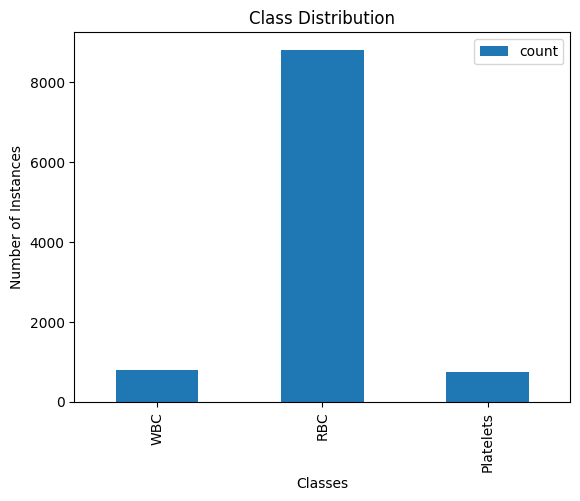

Calsses in counter: Counter({1: 8814, 2: 789, 0: 739})


In [8]:
# check classes available in label files

class_counts = Counter()
for label_file in label_paths:
    with open(label_file, "r") as file:
        lines = file.readlines()
    class_counts.update(Counter([int(line.split()[0]) for line in lines]))

# Replace class IDs with class names
class_counts_names = {class_names[int(class_id)]: count for class_id, count in class_counts.items()}

# Create a pandas DataFrame and plot the bar chart
df = pd.DataFrame.from_dict(class_counts_names, orient="index", columns=["count"])
ax = df.plot(kind="bar")
plt.xlabel("Classes")
plt.ylabel("Number of Instances")
plt.title("Class Distribution")
plt.show()

print("Calsses in counter:", class_counts)

In [9]:
data = []

for file in label_paths:
    with open(file) as f:
        lines = f.readlines()
        num_lines = len(lines)
        unique_values = len(set(list(map(lambda x: x.split()[0], lines))))
        
        data.append([file, num_lines, unique_values])

df = pd.DataFrame(data, columns=['file', 'num_lines', 'unique_values'])

<Axes: xlabel='num_lines'>

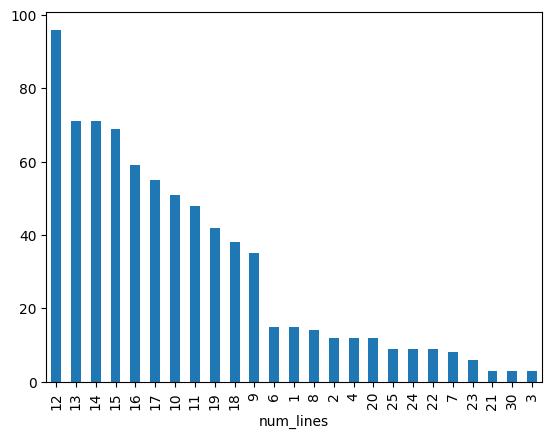

In [10]:
# distribution of number of detections in an image
df['num_lines'].value_counts().plot(kind='bar')

<Axes: xlabel='unique_values'>

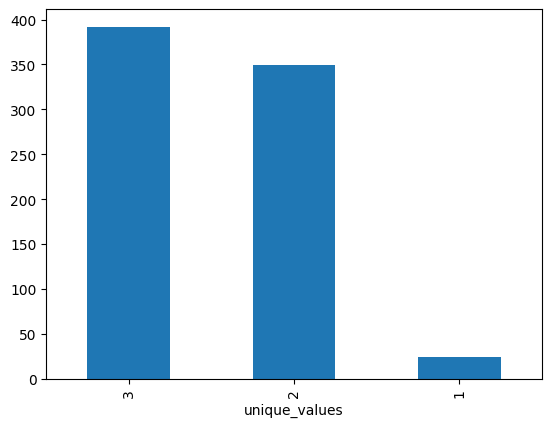

In [11]:
# distribution of number of unique classes in images
df['unique_values'].value_counts().plot(kind='bar')

Most images have either 2 or 3 classes in them. 

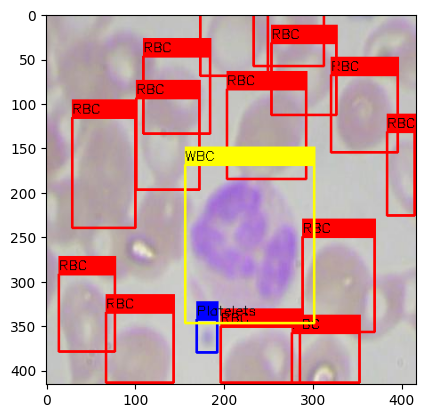

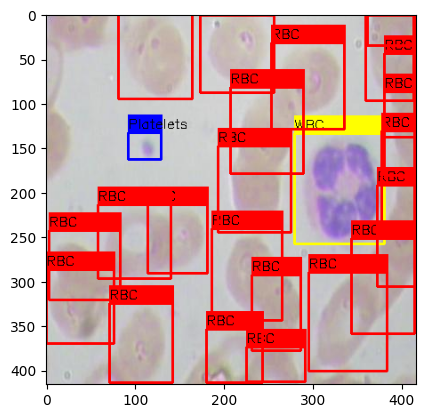

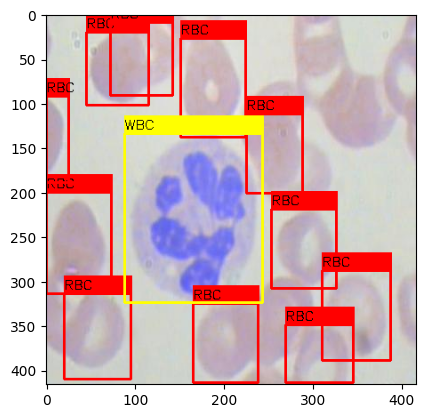

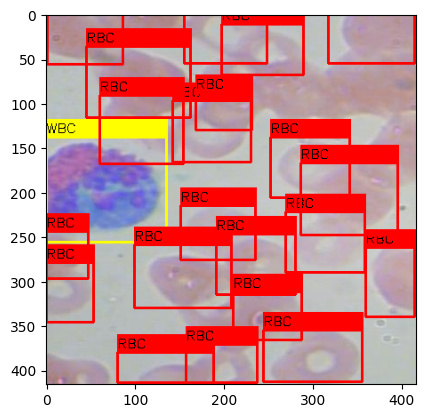

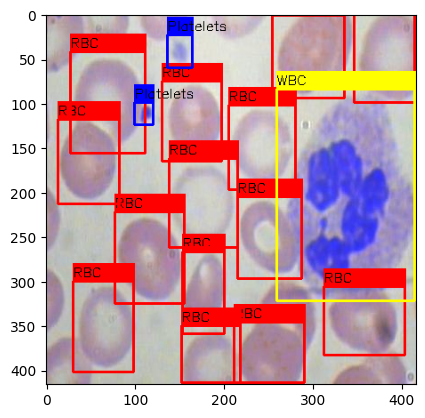

In [12]:
# Number of images to randomly select
num_images = 5

# Get the list of all image files in the 'images' directory
image_files = [f for f in pathlib.Path(images_dir).iterdir() if f.is_file()]

# Shuffle the list of image files
random.shuffle(image_files)

# Select the specified number of image files
selected_image_files = image_files[:num_images]

for selected_image_file in selected_image_files:
    demo_image = selected_image_file
    # Get the corresponding label file
    demo_label = pathlib.Path(labels_dir) / f"{selected_image_file.stem}.txt"

    # Load the image using OpenCV's function
    image = cv2.imread(str(demo_image))

    # Get the list of class names from the 'data' dictionary
    class_list = data_yaml['names']

    # Define a list of colors to be used to draw bounding boxes
    colors = [(255, 0, 0), (0, 0, 255), (0, 255, 255)]
    
    # Get the height and width of the image
    height, width, _ = image.shape

    # Create an empty list T
    T = []

    # Open the label file 'demo_label' in read mode and process each line
    with open(demo_label, "r") as file1:
        for line in file1.readlines():
            # Split the line into a list of strings
            split = line.split(" ")

            # Get the class id from the first element of the split list
            class_id = int(split[0])

            # Get the color corresponding to the class id from the 'colors' list
            color = colors[class_id]
            clazz = class_list[class_id]

            # Get the x, y, w, h bounding box coordinates from the split list
            x, y, w, h = float(split[1]), float(split[2]), float(split[3]), float(split[4])

            # Rescale the x, y, w, h values to the size of the image
            box = [int((x - 0.5*w)* width), int((y - 0.5*h) * height), int(w*width), int(h*height)]

            # Draw a rectangle on the image using the 'box' and 'color' values
            cv2.rectangle(image, box, color, 2)

            # Draw a filled rectangle for the class label on the image
            cv2.rectangle(image, (box[0], box[1] - 20), (box[0] + box[2], box[1]), color, -1)

            # Write the class label on the image
            cv2.putText(image, class_list[class_id], (box[0], box[1] - 5), cv2.FONT_HERSHEY_SIMPLEX, .5, (0,0,0))

        # Show the image using matplotlib
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        # Optionally resize the image (commented out in code)
        image = cv2.resize(image, (600, 600))
        plt.show()

<h3> Prepare YOLO model</h3>

In [13]:
baseline_model = YOLO('yolov8x.pt')

In [14]:
print(os.path.exists(cur_dir+"\\data.yaml"))

True


In [15]:
# set base model parameters
params = {
    'data':'data.yaml',
    'imgsz':416,
    'epochs':25,
    'optimizer':'Adam',
    'pretrained':True,
    'lr0':0.1,
    'lrf': 0.00001,
    'cos_lr': True
}

# learning rate is decreasing with epochs according to formula:
# lr_i = 0.5 * (1 + cos(epoch / epochs * pi)) * lr0
# where lr0 - initial learning rate
#       cos_lr - flag to change learning rate according to cos
#       lrf - final learning rate, to prevent it to be too small at the last epoch

In [16]:
# model parameter to prevent overfitting
params['label_smoothing'] = 0.15

In [17]:
# augmentation parameters
params['hsv_h'] = 0.02
params['hsv_s'] = 0.50
params['hsv_v'] = 0.30
params['degrees'] = 5.0
params['translate'] = 0.05
params['scale'] = 0.3
params['shear'] = 0.0
params['perspective'] = 0.0
params['flipud'] = 0.0
params['fliplr'] = 0.30
params['mosaic'] = 0.50
params['mixup'] = 0.0

In [18]:
# focal loss parameter, useful for unballanced source data like we have in CBC detection
#params['fl_gamma'] = 2

In [19]:
# additioanl paraeters for better bounding box detection and decreasing false positive classes 
params['box'] = 10.0
params['cls'] = 2.0
params['dfl'] = 2.0

In [20]:
params

{'data': 'data.yaml',
 'imgsz': 416,
 'epochs': 25,
 'optimizer': 'Adam',
 'pretrained': True,
 'lr0': 0.1,
 'lrf': 1e-05,
 'cos_lr': True,
 'label_smoothing': 0.15,
 'hsv_h': 0.02,
 'hsv_s': 0.5,
 'hsv_v': 0.3,
 'degrees': 5.0,
 'translate': 0.05,
 'scale': 0.3,
 'shear': 0.0,
 'perspective': 0.0,
 'flipud': 0.0,
 'fliplr': 0.3,
 'mosaic': 0.5,
 'mixup': 0.0,
 'box': 10.0,
 'cls': 2.0,
 'dfl': 2.0}

In [21]:
results = baseline_model.train(**params)

New https://pypi.org/project/ultralytics/8.1.12 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.222 🚀 Python-3.9.1 torch-2.1.1+cpu CPU (Intel Core(TM) i7-7820HQ 2.90GHz)
engine\trainer: task=detect, mode=train, model=yolov8x.pt, data=data.yaml, epochs=25, patience=50, batch=16, imgsz=416, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train8, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, show=False, save_frames=False, save_txt=False, save_conf=False, save_cr

train: Scanning C:\Users\Artem\PycharmProjects\CBC_01\train\labels.cache... 765 images, 0 backgrounds, 0 corrupt: 100%|
val: Scanning C:\Users\Artem\PycharmProjects\CBC_01\valid\labels.cache... 73 images, 0 backgrounds, 0 corrupt: 100%|███


Plotting labels to runs\detect\train8\labels.jpg... 
optimizer: Adam(lr=0.1, momentum=0.937) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 0 dataloader workers
Logging results to runs\detect\train8
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25         0G      3.705      14.57      3.552        211        416: 100%|██████████| 48/48 [29:08<00:00, 36.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [01:40<0

                   all         73        967          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25         0G      3.633      10.23      3.461        208        416: 100%|██████████| 48/48 [28:04<00:00, 35.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [01:20<0

                   all         73        967   0.000343    0.00463   0.000263   0.000142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25         0G      3.518       11.4      3.451        179        416: 100%|██████████| 48/48 [27:00<00:00, 33.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [01:37<0

                   all         73        967   0.000658     0.0926   0.000568   0.000198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25         0G      3.315      10.17      3.372        214        416: 100%|██████████| 48/48 [27:26<00:00, 34.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:58<0

                   all         73        967     0.0365     0.0997     0.0332     0.0122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25         0G      3.269      9.479      3.385        208        416: 100%|██████████| 48/48 [28:56<00:00, 36.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:58<0

                   all         73        967    0.00435      0.116    0.00319    0.00114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25         0G       3.27      9.361      3.507        212        416: 100%|██████████| 48/48 [26:26<00:00, 33.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [01:00<0

                   all         73        967     0.0402      0.112     0.0404     0.0113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25         0G      3.144      9.342      3.414        254        416: 100%|██████████| 48/48 [26:09<00:00, 32.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [01:02<0

                   all         73        967      0.252     0.0603      0.135     0.0359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25         0G      3.085      9.937      3.356        215        416: 100%|██████████| 48/48 [26:30<00:00, 33.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:57<0

                   all         73        967      0.456     0.0636     0.0734     0.0274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25         0G      3.064      8.851      3.373        196        416: 100%|██████████| 48/48 [26:41<00:00, 33.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [01:09<0

                   all         73        967      0.058     0.0692     0.0535     0.0172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25         0G      2.992      8.117      3.284        216        416: 100%|██████████| 48/48 [32:57<00:00, 41.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [01:00<0

                   all         73        967      0.819      0.214      0.251     0.0994



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25         0G      2.872      7.977       3.21        204        416: 100%|██████████| 48/48 [29:29<00:00, 36.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [01:02<0

                   all         73        967    0.00465      0.259     0.0787     0.0283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25         0G      2.709      7.301      3.095        149        416: 100%|██████████| 48/48 [28:53<00:00, 36.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [01:11<0

                   all         73        967      0.377        0.4      0.354     0.0753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25         0G      2.659      6.616      3.106        242        416: 100%|██████████| 48/48 [29:35<00:00, 36.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [01:06<0

                   all         73        967      0.698       0.34      0.338      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25         0G      2.555      6.411      2.965        190        416: 100%|██████████| 48/48 [30:31<00:00, 38.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [01:07<0

                   all         73        967      0.676      0.427      0.502      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25         0G       2.51      6.431      3.003        217        416: 100%|██████████| 48/48 [34:59<00:00, 43.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [01:37<0

                   all         73        967      0.676      0.427      0.502      0.186


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25         0G      2.341      5.604      2.866        171        416: 100%|██████████| 48/48 [37:15<00:00, 46.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:57<0

                   all         73        967      0.778      0.262      0.563      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25         0G      2.247      5.236      2.756        144        416: 100%|██████████| 48/48 [27:26<00:00, 34.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:58<0

                   all         73        967      0.612      0.737      0.769      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25         0G      2.195      5.054      2.694        175        416: 100%|██████████| 48/48 [27:51<00:00, 34.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:57<0

                   all         73        967      0.637      0.775      0.743      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25         0G       2.14      4.788      2.665        165        416: 100%|██████████| 48/48 [26:50<00:00, 33.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:58<0

                   all         73        967      0.701      0.788      0.812      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25         0G      2.113      4.714       2.62        181        416: 100%|██████████| 48/48 [27:24<00:00, 34.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [01:07<0

                   all         73        967      0.687      0.806      0.782       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25         0G      2.081      4.612      2.599        151        416: 100%|██████████| 48/48 [28:14<00:00, 35.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:57<0

                   all         73        967      0.689      0.682      0.772      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25         0G      2.029      4.466      2.566        168        416: 100%|██████████| 48/48 [26:30<00:00, 33.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:57<0

                   all         73        967      0.783      0.739      0.824      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25         0G      1.991      4.378      2.526        153        416: 100%|██████████| 48/48 [26:14<00:00, 32.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:56<0

                   all         73        967      0.699      0.827      0.825      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25         0G      1.958      4.323      2.499        195        416: 100%|██████████| 48/48 [26:28<00:00, 33.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:58<0

                   all         73        967      0.734      0.842      0.864      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25         0G       1.93      4.238      2.466        161        416: 100%|██████████| 48/48 [26:43<00:00, 33.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:56<0

                   all         73        967      0.811      0.847       0.87      0.489



25 epochs completed in 12.373 hours.
Optimizer stripped from runs\detect\train8\weights\last.pt, 136.7MB
Optimizer stripped from runs\detect\train8\weights\best.pt, 136.7MB

Validating runs\detect\train8\weights\best.pt...
Ultralytics YOLOv8.0.222 🚀 Python-3.9.1 torch-2.1.1+cpu CPU (Intel Core(TM) i7-7820HQ 2.90GHz)
Model summary (fused): 268 layers, 68126457 parameters, 0 gradients, 257.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [01:02<0


                   all         73        967      0.806      0.866      0.871      0.487
             Platelets         73         76      0.789      0.842      0.843      0.344
                   RBC         73        819      0.718      0.756      0.802      0.498
                   WBC         73         72      0.912          1      0.968      0.618
Speed: 2.2ms preprocess, 837.7ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs\detect\train8


In [22]:
results = baseline_model([cur_dir+'\\AVCheck\\1.jpg'])


0: 416x416 2 Plateletss, 15 RBCs, 1 WBC, 627.0ms
Speed: 3.0ms preprocess, 627.0ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 416)


In [23]:
# Process results list
for result in results:
    boxes = result.boxes  # Boxes object for bbox outputs
    masks = result.masks  # Masks object for segmentation masks outputs
    keypoints = result.keypoints  # Keypoints object for pose outputs
    probs = result.probs  # Probs object for classification outputs

In [24]:
baseline_model = YOLO(cur_dir+'\\runs\\detect\\train6\\weights\\best.pt')
results = baseline_model.predict(cur_dir+'\\AVCheck\\1.jpg', save=True, save_txt=True)
print(cur_dir+'\\runs\\detect\\train6\\weights\\best.pt')


image 1/1 C:\Users\Artem\PycharmProjects\CBC_01\AVCheck\1.jpg: 416x416 1 Platelets, 14 RBCs, 1 WBC, 658.0ms
Speed: 2.0ms preprocess, 658.0ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 416)
Results saved to runs\detect\predict3
1 label saved to runs\detect\predict3\labels
C:\Users\Artem\PycharmProjects\CBC_01\runs\detect\train6\weights\best.pt
